# Hack or Hammer: Can Neural Networks Classify Stellar Types?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# These are the NN layers we'll be using
from keras.models import Sequential #the model is built adding layers one after the other
from keras.layers import Dense #fully connected layers: every output talks to every input
from keras.layers import Dropout #for regularization
from keras.utils import to_categorical
from keras_tuner.tuners import RandomSearch
from keras import layers

2025-04-13 16:08:20.967987: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-13 16:08:21.008406: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Introduction
- What is spectral classes?
- Attach example spectra
- Saha's equation + Boltzman's equation

In [2]:
df = pd.read_csv('SDSS.csv', header = 1)
df.dtypes

specObjID          uint64
sourceType         object
ra                float64
dec               float64
class              object
subclass           object
class_noqso        object
subClass_noqso     object
u                 float64
g                 float64
r                 float64
i                 float64
z1                float64
err_u             float64
err_g             float64
err_r             float64
err_i             float64
err_z             float64
dered_u           float64
dered_g           float64
dered_r           float64
dered_i           float64
dered_z           float64
elodieSpType       object
elodieBV          float64
elodieTEff          int64
elodieLogG        float64
elodieFeH         float64
dtype: object

## Data exploration
This is not a easy problem! <br>
Why?: 

number of rows after filtering: 74123


/tmp/ipykernel_22465/3342819147.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(grouped_temps, labels=class_labels, patch_artist=True,


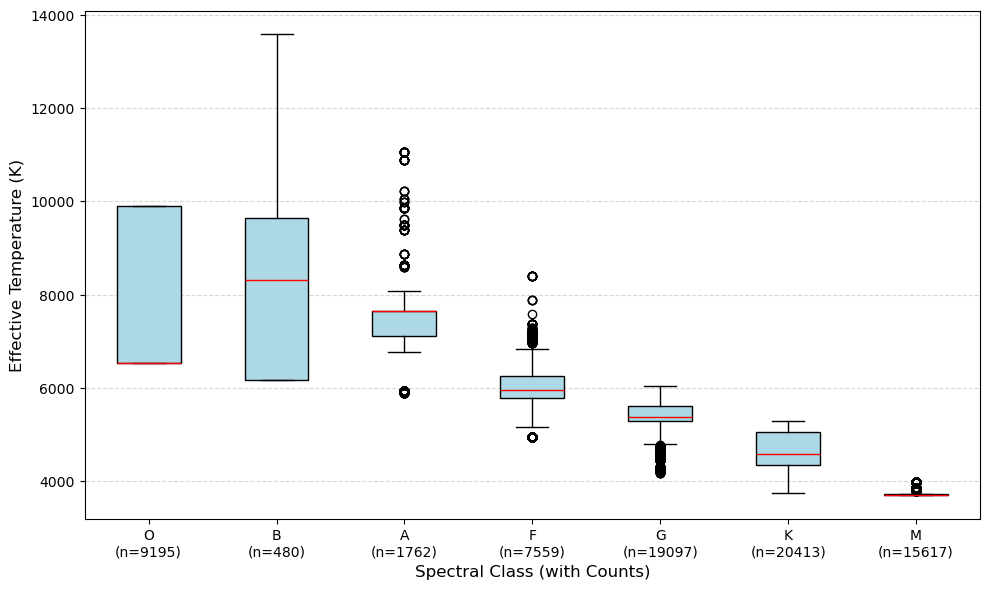

In [3]:
# Extract first letter of spectral type
df['SpClass'] = df['elodieSpType'].str[0]

# Filter to valid spectral types and remove NaNs
valid_classes = ['O', 'B', 'A', 'F', 'G', 'K', 'M']
df = df[df['SpClass'].isin(valid_classes)].dropna(subset=['elodieTEff'])
print(f'number of rows after filtering: {df.shape[0]}')

# Group TEff values and count per class
grouped_temps = []
class_labels = []

for cls in valid_classes:
    class_data = df[df['SpClass'] == cls]['elodieTEff'].values
    grouped_temps.append(class_data)
    class_labels.append(f"{cls}\n(n={len(class_data)})")  # Add count in label

# Plot
plt.figure(figsize=(10, 6))
plt.boxplot(grouped_temps, labels=class_labels, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='black'),
            medianprops=dict(color='red'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'))

plt.xlabel('Spectral Class (with Counts)', fontsize = 'large')
plt.ylabel('Effective Temperature (K)', fontsize = 'large')
# plt.title('Effective Temperature by Spectral Class', fontsize = 'xx-large')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


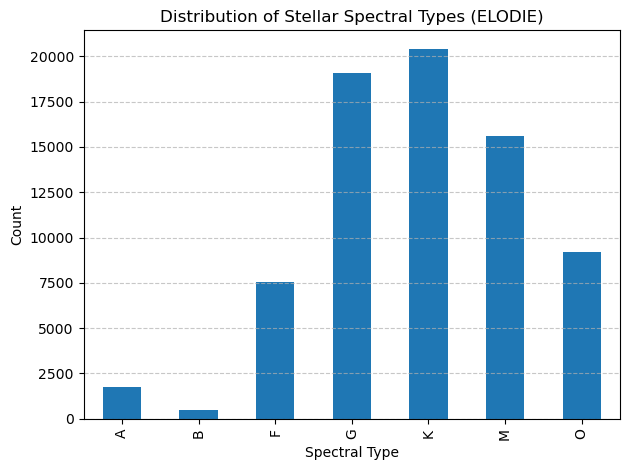

In [4]:
# Extract first letter and count frequencies
spectral_counts = df['elodieSpType'].str[0].value_counts().sort_index()

# Bar plot
spectral_counts.plot(kind='bar')
plt.xlabel('Spectral Type')
plt.ylabel('Count')
plt.title('Distribution of Stellar Spectral Types (ELODIE)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

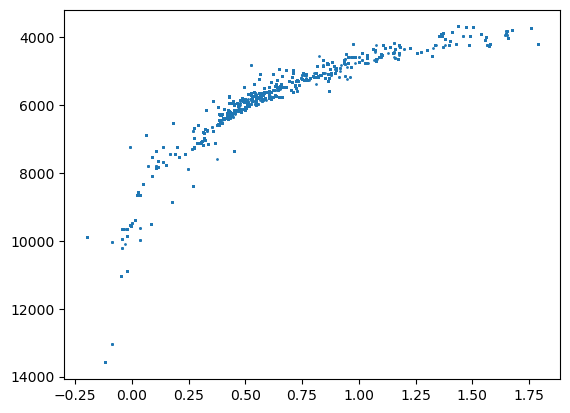

In [5]:
plt.scatter(df['elodieBV'], df['elodieTEff'], s = 1)
plt.gca().invert_yaxis()

## Approach
- What is neural network?
- How it can be useful and not useful?
- What is CV?
- Explain why this model choice is suitable for the dataset
- Strength and weakness of this method

## Initial Results
### Benchmark model


In [6]:
df['dummySpClass'] = df['elodieTEff'].apply(
    lambda T: 'M' if T < 4000 else ('K' if T <= 6000 else 'O')
)
np.mean(df['dummySpClass'] == df['SpClass'])

0.5636442129973153

In [7]:
# Select only the numeric columns from the SDSS DataFrame
numeric_col = df.select_dtypes(include='number').columns.tolist()
numeric_col = [col for col in numeric_col if col not in ['specObjID', 'err_u', 'err_g', 'err_r', 'err_i', 'err_z']]
X = df[numeric_col]
y = df['SpClass']
print(X.columns)

Index(['ra', 'dec', 'u', 'g', 'r', 'i', 'z1', 'dered_u', 'dered_g', 'dered_r',
       'dered_i', 'dered_z', 'elodieBV', 'elodieTEff', 'elodieLogG',
       'elodieFeH'],
      dtype='object')


#### Data Splitting

In [8]:
# Shuffle the data and target labels while preserving the correspondence
X,y = shuffle(X,y, random_state = 406)
# slight modification to the catergorical output
# Your custom mapping (example: skip every other integer)
le = LabelEncoder()
y_encoded = le.fit_transform(y)          # Converts to integers: [0, 1, 2, ...]
y_categorical = to_categorical(y_encoded)  # One-hot encode

# --- Manually splitting our dataset
# Use 70/20/10 split here
split1 = int(0.7*len(X))
split2 = int(0.9*len(X))
# First 70% samples will be the training set
X_train = X.values[:split1,:]
y_train = y_categorical[:split1]
# Next 20% samples will be the validation set, used to minimize loss function
X_val = X.values[split1:split2,:]
y_val = y_categorical[split1:split2]
# Last 10% samples will be the test set, used to test the model performance
X_test = X.values[split2:,:]
y_test = y_categorical[split2:]

# use StandardScaler() to scale the dataset
scaler = StandardScaler()
scaler.fit(X_train)

Xst_train = scaler.transform(X_train)
Xst_val = scaler.transform(X_val)
Xst_test = scaler.transform(X_test)

# Confirm the shapes of the datasets
print(X_train.shape, X_val.shape, X_test.shape)

(51886, 16) (14824, 16) (7413, 16)


#### The number of parameters
<span style="color:red">calculate the number of parameters and compare with size of dataset</span>.

In [9]:
# Set up the NN model with the 3 layers
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(Xst_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1], activation='softmax'))

# set up and assign the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# compile the model
model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics =['accuracy'])
mynet = model.fit(Xst_train, y_train, validation_data= (Xst_val, y_val), epochs = 50, batch_size=200)

Epoch 1/50


/home/yanbopan/anaconda3/envs/astro-416/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7169 - loss: 0.7377 - val_accuracy: 0.9396 - val_loss: 0.1606
Epoch 2/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9134 - loss: 0.2830 - val_accuracy: 0.9554 - val_loss: 0.1400
Epoch 3/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9319 - loss: 0.2087 - val_accuracy: 0.9615 - val_loss: 0.1059
Epoch 4/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9428 - loss: 0.1687 - val_accuracy: 0.9667 - val_loss: 0.1029
Epoch 5/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9457 - loss: 0.1525 - val_accuracy: 0.9680 - val_loss: 0.0900
Epoch 6/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9457 - loss: 0.1519 - val_accuracy: 0.9689 - val_loss: 0.0893
Epoch 7/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9463 - loss: 0.1946 - val_accuracy: 0.9671 - val_loss: 0.0876
Epoch 8/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9496 - loss: 0.1367 - val_accuracy: 0.9715 - val_

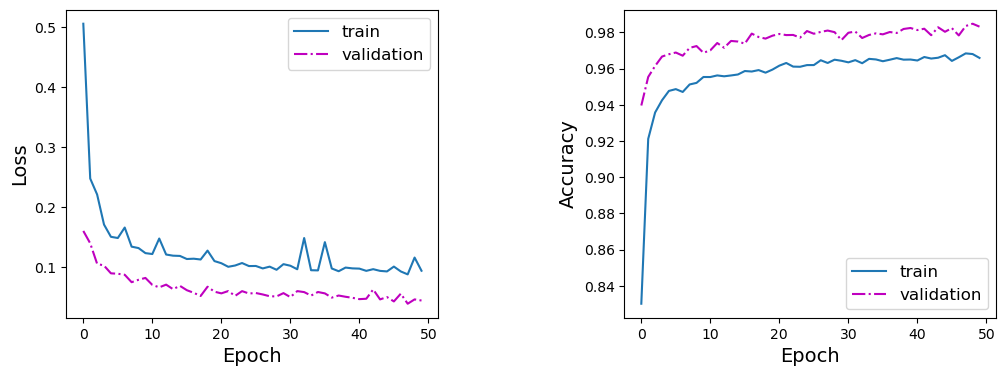

In [10]:
fig = plt.figure(figsize=(12, 4))
plt.subplot(121)

plt.plot(mynet.history['loss'], label = 'train')
plt.plot(mynet.history['val_loss'],'-.m', label = 'validation')
# plt.yscale('log')
plt.ylabel('Loss', fontsize = 14)
plt.xlabel('Epoch', fontsize = 14)
plt.legend(loc='upper right', fontsize = 12)

plt.subplot(122)

plt.plot(mynet.history['accuracy'], label = 'train')
plt.plot(mynet.history['val_accuracy'], '-.m', label = 'validation')
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Epoch', fontsize = 14)
plt.legend(fontsize = 12)
plt.subplots_adjust(wspace=0.5)

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


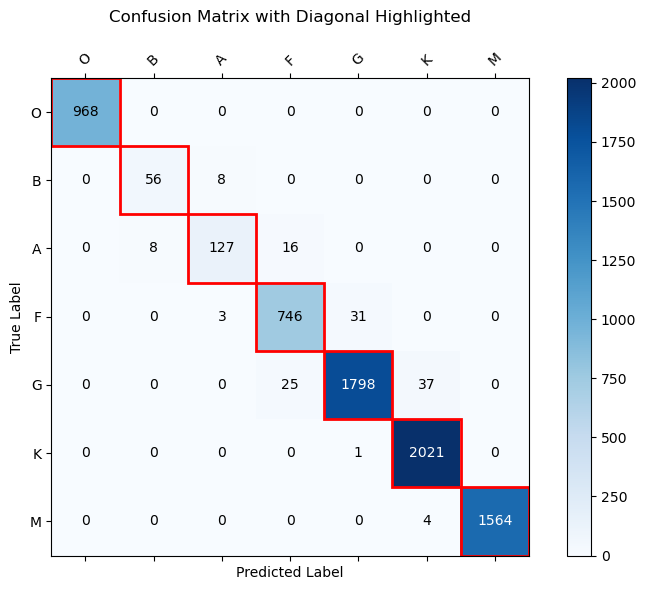

In [11]:
y_pred_probs = model.predict(Xst_test)

# Get predicted class indices
y_pred_classes = y_pred_probs.argmax(axis=1)

# Decode both true and predicted labels to original string labels
y_test_labels = le.inverse_transform(y_test.argmax(axis=1))      # if y_test is one-hot
y_pred_labels = le.inverse_transform(y_pred_classes)

# Define your desired spectral order
ordered_labels = ['O', 'B', 'A', 'F', 'G', 'K', 'M']

# Create the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=ordered_labels)
labels = ordered_labels

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(cm, cmap='Blues')

# Add colorbar
fig.colorbar(cax)

# Add class labels to axes
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45)
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix with Diagonal Highlighted', pad=20)

# Annotate each cell with its value
for i in range(len(labels)):
    for j in range(len(labels)):
        ax.text(j, i, str(cm[i, j]),
                va='center', ha='center',
                color='white' if cm[i, j] > cm.max()/2 else 'black')

# Draw red rectangles around diagonal cells
for i in range(len(labels)):
    rect = plt.Rectangle((i - 0.5, i - 0.5), 1, 1, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

plt.tight_layout()
plt.show()

<span style="color:red">Create customized metrics here</span>.
#### I will be sad if a O star is being labelled as M

### Hyperparameter tuning

In [12]:
# Fill in the code from the textbook
##### Add more hyperparameter tuning
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 4)):
        model.add(layers.Dense(units = hp.Int('units_' + str(i),
        min_value = 16, max_value = 64, step = 16), activation = 'relu'))
    model.add(Dense(y_train.shape[1], activation = 'softmax'))
    model.compile(optimizer = tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])), loss = 'mse')
    return model

In [13]:
tf.keras.backend.clear_session() # clear the session to avoid clutter from old models

# Set up the tuner variable (see book) and provide comments to describe what is happening
tuner = RandomSearch(build_model, objective='val_loss', max_trials = 3, executions_per_trial = 3, project_name = 'SpectralClass')
# build_model: provide a series of model (parameters) to tune/choose
# objective: specifies the direction of the optimization and what loss function to use on which dataset. 
# max_trials: the totoal number of trials to test at most for the random search
# executions_per_trial: since the model performance is dependent on the the intial condition, therefore, it is good to run models several times
#                        here, we run each model 3 times to average the randomness
# project_name: name of the directory where tuning results will be saved

tuner.search_space_summary()

Reloading Tuner from ./SpectralClass/tuner0.json
Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}


In [14]:
### takes a long time to run ###
tuner.search(Xst_train, y_train, epochs = 20, validation_data = (Xst_val, y_val), batch_size = 300, verbose = 0)

In [15]:
tuner.results_summary(2)

Results summary
Results in ./SpectralClass
Showing 2 best trials
Objective(name="val_loss", direction="min")

Trial 2 summary
Hyperparameters:
num_layers: 2
units_0: 32
units_1: 64
learning_rate: 0.01
units_2: 16
units_3: 16
Score: 0.008086962004502615

Trial 1 summary
Hyperparameters:
num_layers: 4
units_0: 64
units_1: 32
learning_rate: 0.001
units_2: 16
units_3: 16
Traceback (most recent call last):
  File "/home/yanbopan/anaconda3/envs/astro-416/lib/python3.11/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/home/yanbopan/anaconda3/envs/astro-416/lib/python3.11/site-packages/keras_tuner/src/engine/base_tuner.py", line 265, in _run_and_update_trial
    tuner_utils.convert_to_metrics_dict(
  File "/home/yanbopan/anaconda3/envs/astro-416/lib/python3.11/site-packages/keras_tuner/src/engine/tuner_utils.py", line 132, in convert_to_metrics_dict
    [convert_to_metrics_dict(el

In [16]:
best_hps = tuner.get_best_hyperparameters()[0] #choose first model

print('Best learning rate:', best_hps.get('learning_rate'))
print('Best number of layers:', best_hps.get('num_layers'))

print('Best units in layer 0:', best_hps.get('units_0'))
print('Best units in layer 1:', best_hps.get('units_1'))

Best learning rate: 0.01
Best number of layers: 2
Best units in layer 0: 32
Best units in layer 1: 64


In [17]:
model = tuner.hypermodel.build(best_hps) #define model = best model
model.build(input_shape=(None,Xst_train.shape[1])) #build best model (if not fit yet, this will give access to summary)
model.summary() #print summary of the best model

bestnet = model.fit(Xst_train, y_train, validation_data= (Xst_val, y_val), epochs=20, batch_size=300)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,111 (12.15 KB)

 Trainable params: 3,111 (12.15 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0478 - val_loss: 0.0167
Epoch 2/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0159 - val_loss: 0.0121
Epoch 3/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0127 - val_loss: 0.0110
Epoch 4/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0119 - val_loss: 0.0107
Epoch 5/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0110 - val_loss: 0.0114
Epoch 6/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107 - val_loss: 0.0095
Epoch 7/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0111 - val_loss: 0.0097
Epoch 8/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097 - val_loss: 0.0094
Epoch 9/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107 - val_loss: 0.0090
Epoch 10/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097 - val_loss: 0.0094
Epoch 11/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0099 - val_loss: 0.0086
Epoch 12/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

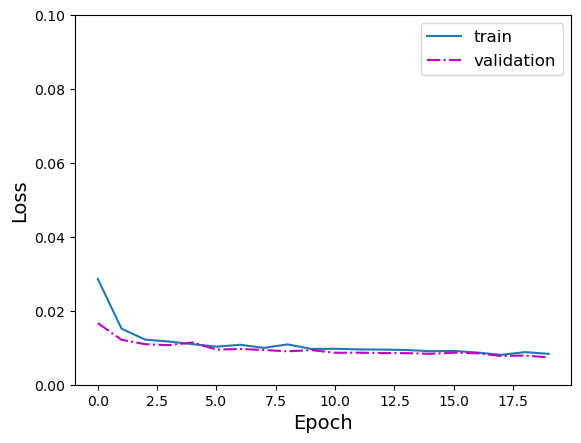

In [18]:
plt.plot(bestnet.history['loss'], label = 'train')
plt.plot(bestnet.history['val_loss'],'-.m', label = 'validation')
plt.ylabel('Loss', fontsize = 14)
plt.xlabel('Epoch', fontsize = 14)
plt.ylim(0,0.1)
plt.legend(loc='upper right', fontsize = 12)
plt.legend(fontsize = 12)

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


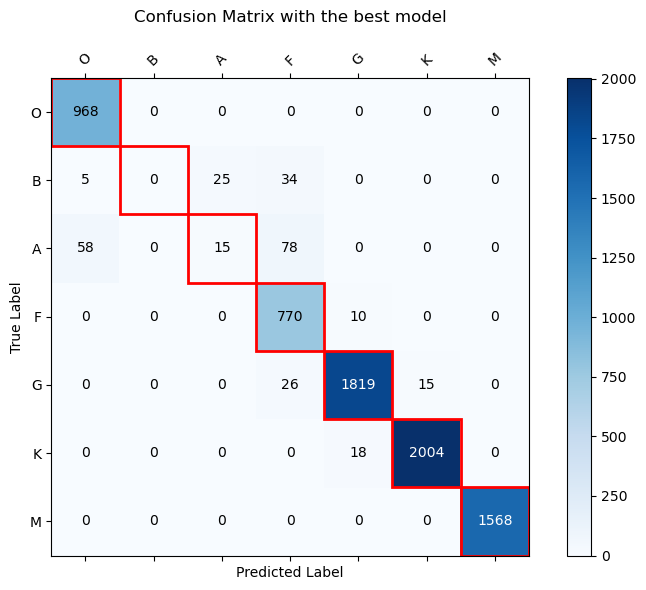

In [19]:
y_pred_probs = model.predict(Xst_test)

# Get predicted class indices
y_pred_classes = y_pred_probs.argmax(axis=1)

# Decode both true and predicted labels to original string labels
y_test_labels = le.inverse_transform(y_test.argmax(axis=1))      # if y_test is one-hot
y_pred_labels = le.inverse_transform(y_pred_classes)

# Define your desired spectral order
ordered_labels = ['O', 'B', 'A', 'F', 'G', 'K', 'M']

# Create the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=ordered_labels)
labels = ordered_labels

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(cm, cmap='Blues')

# Add colorbar
fig.colorbar(cax)

# Add class labels to axes
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45)
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix with the best model', pad=20)

# Annotate each cell with its value
for i in range(len(labels)):
    for j in range(len(labels)):
        ax.text(j, i, str(cm[i, j]),
                va='center', ha='center',
                color='white' if cm[i, j] > cm.max()/2 else 'black')

# Draw red rectangles around diagonal cells
for i in range(len(labels)):
    rect = plt.Rectangle((i - 0.5, i - 0.5), 1, 1, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

plt.tight_layout()
plt.show()

## Final Results

### Confusion matrics

## Reflection

## AI Statement